In [36]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt

In [37]:
#device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device = "cpu"
# TODO: make sure to .to(device) the class later, and also set up gpu

# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0
# number of epochs
num_epochs = 50
# batch size for training
batch_size = 32
# height and width of input image
img_size = 64
# number of channels
nc0 = 1
nc1 = 4
nc2 = 8
nc3 = 16
# threshold
thresh = 0
# learning rate
lr = 0.002
# beta1 for Adam
beta1 = 0.5
# real label
real_label = 1.0
# fake label
fake_label = 0.0

In [38]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [39]:
class FontDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.fontlist = pd.read_csv(csv_file, sep=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fontlist)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path1 = os.path.join(self.root_dir, "R/", f"{idx}.npy")
        img_path2 = os.path.join(self.root_dir, "B/", f"{idx}.npy")

        img1 = np.load(img_path1)
        img2 = np.load(img_path2)

        img1 = img1[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]
        img2 = img2[img_size//2:img_size//2 + img_size, img_size//2:img_size//2 + img_size, :]

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        sample = {'c1': img1, 'c2': img2}

        return sample

In [40]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super(EncoderDecoder, self).__init__()
        self.conv1 = nn.Conv2d(nc0, nc1, 3, padding=1)
        self.conv2 = nn.Conv2d(nc1, nc2, 3, padding=1)
        self.conv3 = nn.Conv2d(nc2, nc2, 3, padding=1)
        self.conv2back = nn.Conv2d(nc2, nc1, 3, padding=1)
        self.conv1back = nn.Conv2d(nc1, nc0, 3, padding=1)
        
        self.conv1strided = nn.Conv2d(nc1, nc1, 3, stride=2, padding=1)
        self.conv2strided = nn.Conv2d(nc2, nc2, 3, stride=2, padding=1)

        self.deconv1 = nn.ConvTranspose2d(nc1, nc0, 3, padding=1)
        self.deconv2 = nn.ConvTranspose2d(nc2, nc1, 3, padding=1)
        self.deconv1strided = nn.ConvTranspose2d(nc1, nc1, 3, stride=2, padding=1, output_padding=1)
        self.deconv2strided = nn.ConvTranspose2d(nc2, nc2, 3, stride=2, padding=1, output_padding=1)

        self.batchnorm0 = nn.BatchNorm2d(nc0)
        self.batchnorm1 = nn.BatchNorm2d(nc1)
        self.batchnorm2 = nn.BatchNorm2d(nc2)
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        self.relu = nn.ReLU(inplace=True)
        self.leakyrelu = nn.LeakyReLU(0.2, inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.threshold = nn.Threshold(thresh, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.conv2(x)
        x = self.leakyrelu(x)
        x, idx1 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx2 = self.pool(x)
        
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x, idx3 = self.pool(x)
        
        x = self.unpool(x, idx3)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx2)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.conv3(x)
        x = self.leakyrelu(x)
        
        x = self.unpool(x, idx1)
        x = self.conv2back(x)
        x = self.leakyrelu(x)
        x = self.conv1back(x)
        x = self.leakyrelu(x)
        
        x = self.tanh(x)
        return x
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)
#         #x, idx1 = self.pool(x)
#         x = self.conv1strided(x)

#         x = self.conv2(x)
#         x = self.batchnorm2(x)
#         x = self.leakyrelu(x)
#         #x, idx2 = self.pool(x)
#         x = self.conv2strided(x)

#         x = self.deconv2strided(x)
#         #x = self.unpool(x, idx2)
#         x = self.deconv2(x)
#         x = self.batchnorm1(x)
#         x = self.leakyrelu(x)

#         x = self.deconv1strided(x)
#         #x = self.unpool(x, idx1)
#         x = self.deconv1(x)
#         x = self.batchnorm0(x)
#         #x = self.relu(x)

#         #x = self.threshold(x)
#         x = self.tanh(x)
#         return x

In [41]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 1 x img_size x img_size
            nn.Conv2d(nc0, nc1, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc1),
            nn.ReLU(inplace=True),
            # 4 x img_size/2 x img_size/2
            nn.Conv2d(nc1, nc2, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc2),
            nn.ReLU(inplace=True),
            # 8 x img_size/4 x img_size/4
            nn.Conv2d(nc2, nc3, 4, stride=2, padding=1),
            nn.BatchNorm2d(nc3),
            nn.ReLU(inplace=True),
            # 16 x img_size/8 x img_size/8
            nn.Flatten(),
            nn.Linear(nc3 * img_size // 8 * img_size // 8, 1),
            nn.Sigmoid(),
        )

    def forward(self, input):
        return self.main(input)

In [42]:
def main():
    dataset = FontDataset(csv_file=fonts_csv, 
                        root_dir=dataroot, 
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(0.5, 0.5),
#                             AddGaussianNoise(0., 0.05),
                        ]))
    
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)
    
    encdec = EncoderDecoder()
    criterionED = nn.L1Loss()
    optimizerED = optim.Adam(encdec.parameters(), lr=lr)

    disc = Discriminator()
    criterionD = nn.BCELoss()
    optimizerD = optim.Adam(disc.parameters(), lr=lr)
    
    # training loop
    for epoch in range(num_epochs):
        running_lossD = 0.0
        running_loss_disc = 0.0
        running_loss_super = 0.0
        for i, data in enumerate(dataloader):
            ###########################
            # update disc
            ###########################
            disc.zero_grad()
            # all real batch
            b_size = data['c2'].size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            outputD = disc(data['c2']).view(-1)
            lossD_real = criterionD(outputD, label)
            lossD_real.backward()
            
            # all fake batch
            outputED = encdec(data['c1'])
            label.fill_(fake_label)
            outputD = disc(outputED.detach()).view(-1)
            lossD_fake = criterionD(outputD, label)
            lossD_fake.backward()

            lossD = lossD_real + lossD_fake
            optimizerD.step()

            ###########################
            # update encdec
            ###########################
            encdec.zero_grad()
            # rerun disc
            label.fill_(real_label)
            outputD = disc(outputED).view(-1)
            lossED_disc = criterionD(outputD, label)
            # run encdec
            lossED_super = criterionED(outputED, data['c2'])

            lossED = 0 * lossED_disc + lossED_super
            lossED.backward()
            optimizerED.step()
    
            running_lossD += lossD.item()
            running_loss_disc += lossED_disc.item()
            running_loss_super += lossED_super.item()
            if i % 50 == 49:
                print(f"Epoch {epoch+1}, Iteration {i+1}, Loss D {running_lossD}, Loss Disc {running_loss_disc}, Loss Super {running_loss_super}")
                running_lossD = 0.0
                running_loss_disc = 0.0
                running_loss_super = 0.0
                
                fig = plt.figure(figsize=(8, 8))
                output = encdec(data['c1'])
                fig.add_subplot(1, 2, 1)
                plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                fig.add_subplot(1, 2, 2)
                plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
                plt.show()
    
    torch.save(encdec.state_dict(), 'encdec.pt')
    print("Done")

Epoch 1, Iteration 50, Loss D 7.83170530339703, Loss Disc 290.7070445418358, Loss Super 40.31081211566925


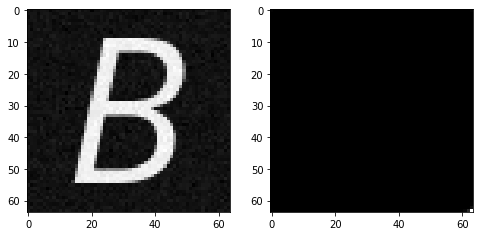

Epoch 1, Iteration 100, Loss D 2.940890197874978, Loss Disc 279.0661425590515, Loss Super 17.13182407617569


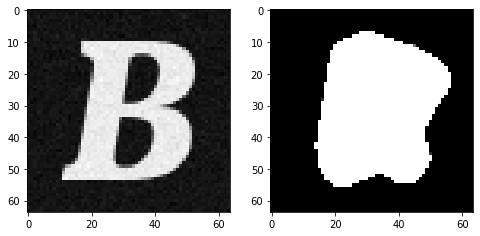

Epoch 2, Iteration 50, Loss D 0.42328055459074676, Loss Disc 348.24366903305054, Loss Super 15.56436675786972


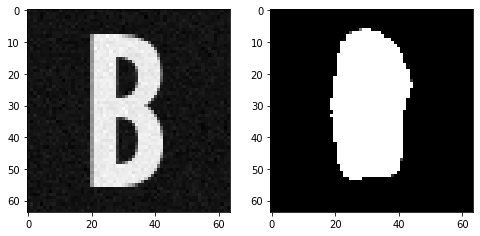

Epoch 2, Iteration 100, Loss D 0.42107067140750587, Loss Disc 376.94042921066284, Loss Super 15.393696755170822


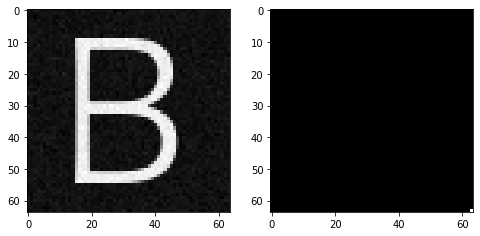

Epoch 3, Iteration 50, Loss D 0.44022399914683774, Loss Disc 358.0854516029358, Loss Super 13.146193757653236


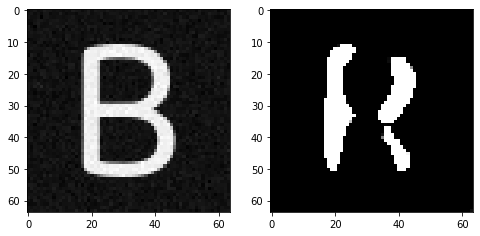

Epoch 3, Iteration 100, Loss D 0.1847379977698438, Loss Disc 401.83444690704346, Loss Super 12.402270957827568


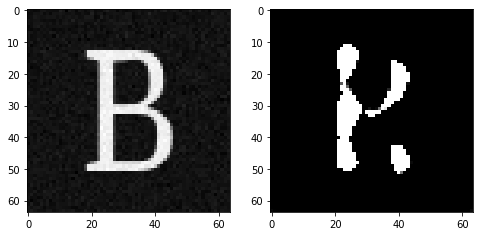

Epoch 4, Iteration 50, Loss D 0.1364083084044978, Loss Disc 402.5841212272644, Loss Super 12.199396699666977


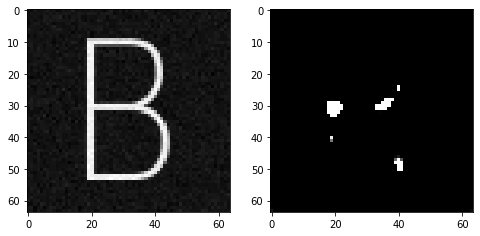

Epoch 4, Iteration 100, Loss D 0.17295278439996764, Loss Disc 400.53056287765503, Loss Super 11.883232578635216


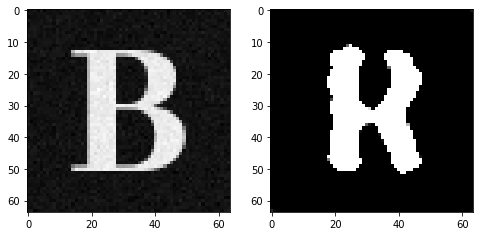

Epoch 5, Iteration 50, Loss D 1.6433739615604281, Loss Disc 369.01038813591003, Loss Super 11.480528801679611


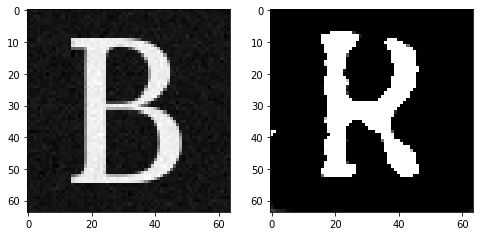

Epoch 5, Iteration 100, Loss D 1.0435689419973642, Loss Disc 425.2956643104553, Loss Super 11.71318356692791


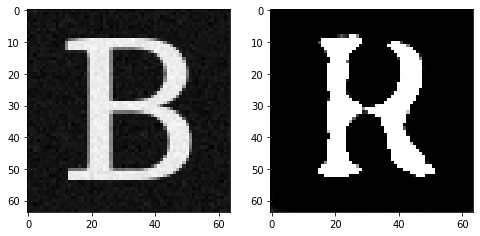

Epoch 6, Iteration 50, Loss D 0.5835395335452631, Loss Disc 441.93704175949097, Loss Super 11.408511027693748


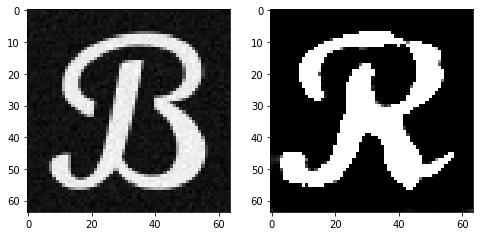

Epoch 6, Iteration 100, Loss D 0.33212668768828735, Loss Disc 438.0091857910156, Loss Super 11.02194131910801


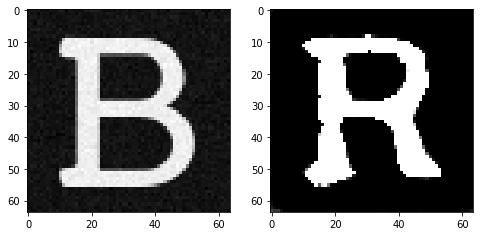

Epoch 7, Iteration 50, Loss D 0.14596723785507493, Loss Disc 466.5593900680542, Loss Super 10.887235537171364


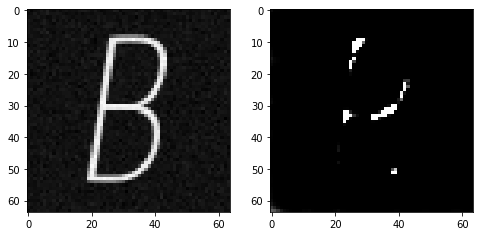

Epoch 7, Iteration 100, Loss D 0.19194681497174315, Loss Disc 464.81957626342773, Loss Super 10.745322406291962


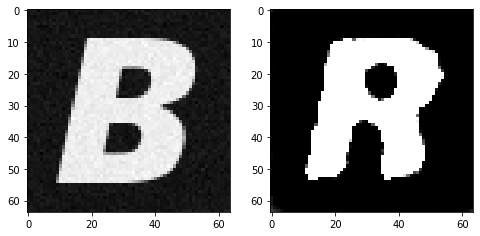

Epoch 8, Iteration 50, Loss D 0.38304414479353, Loss Disc 482.4019732475281, Loss Super 10.587944567203522


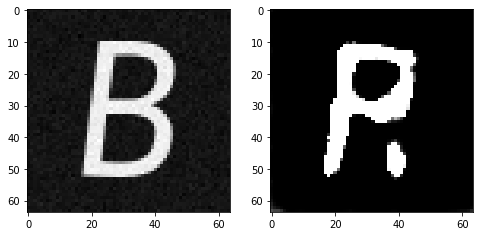

Epoch 8, Iteration 100, Loss D 0.5125801083340775, Loss Disc 500.21487760543823, Loss Super 10.55593691766262


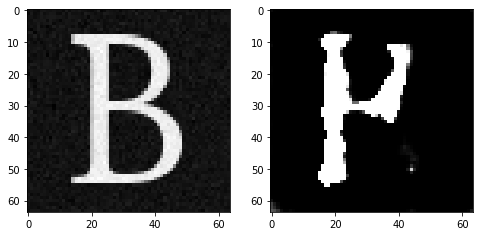

Epoch 9, Iteration 50, Loss D 0.13104461826151237, Loss Disc 497.7267818450928, Loss Super 10.304587066173553


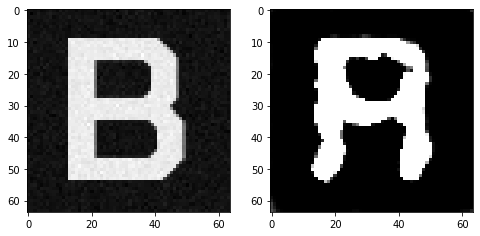

Epoch 9, Iteration 100, Loss D 0.24845699936849996, Loss Disc 487.8490824699402, Loss Super 10.117768347263336


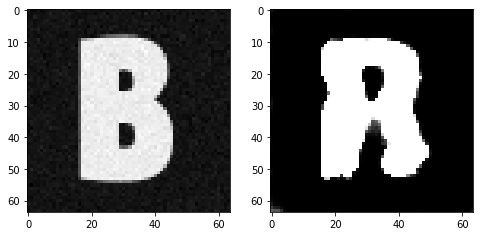

Epoch 10, Iteration 50, Loss D 0.1908136879792437, Loss Disc 516.8953213691711, Loss Super 10.03495991230011


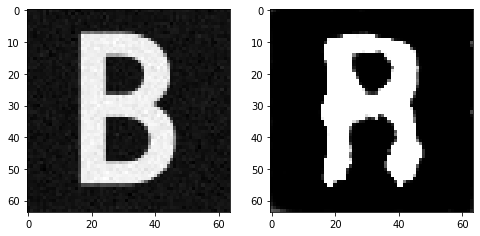

Epoch 10, Iteration 100, Loss D 0.05688022767571965, Loss Disc 554.4192771911621, Loss Super 10.00566153228283


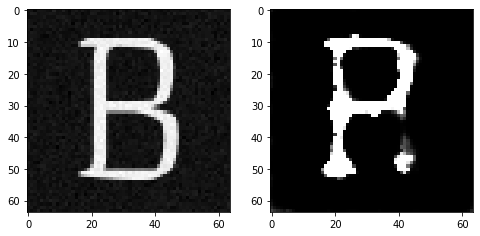

Epoch 11, Iteration 50, Loss D 0.10573975856823381, Loss Disc 573.7341494560242, Loss Super 9.733632862567902


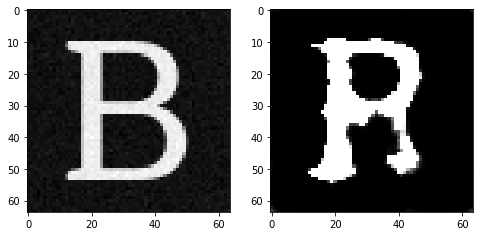

Epoch 11, Iteration 100, Loss D 0.0897120419977, Loss Disc 548.7250409126282, Loss Super 9.739163219928741


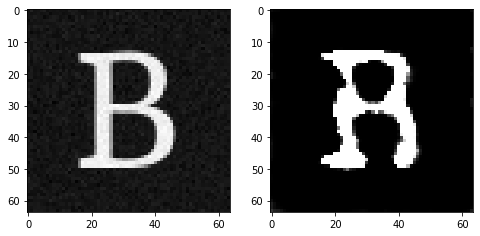

Epoch 12, Iteration 50, Loss D 0.04204672386185848, Loss Disc 574.9313745498657, Loss Super 9.764229193329811


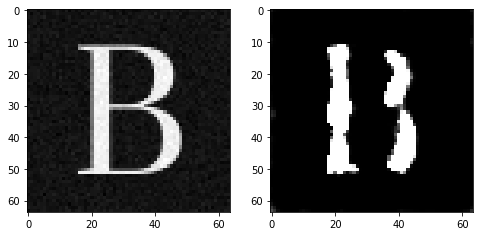

Epoch 12, Iteration 100, Loss D 0.2902635138852929, Loss Disc 525.4600310325623, Loss Super 9.522690802812576


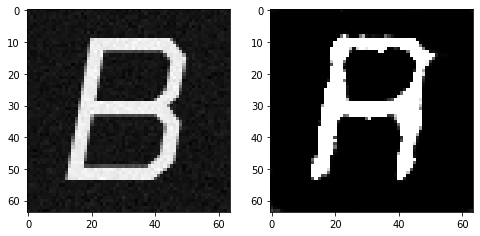

Epoch 13, Iteration 50, Loss D 0.09652939387524384, Loss Disc 567.6946392059326, Loss Super 9.65299578011036


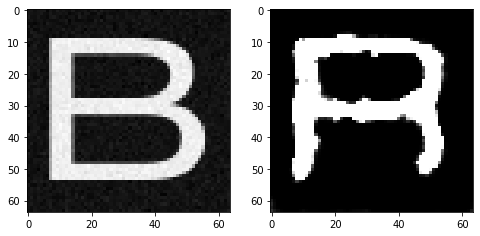

Epoch 13, Iteration 100, Loss D 0.22259601658879546, Loss Disc 562.497841835022, Loss Super 9.292954862117767


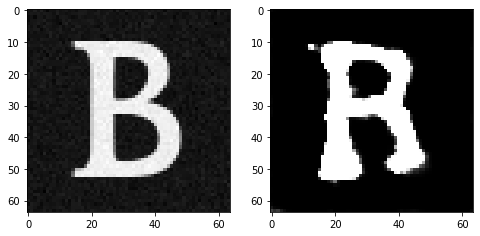

Epoch 14, Iteration 50, Loss D 0.07827849719615187, Loss Disc 565.1944036483765, Loss Super 9.413836508989334


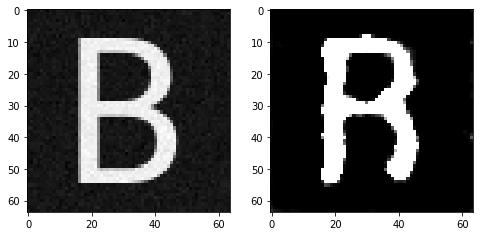

Epoch 14, Iteration 100, Loss D 3.0928199887384835, Loss Disc 556.1193852424622, Loss Super 9.293204724788666


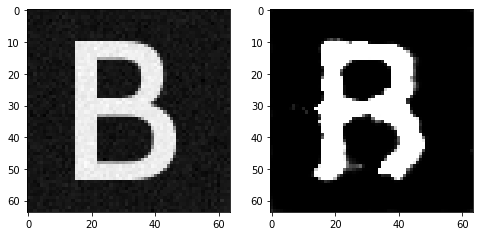

Epoch 15, Iteration 50, Loss D 1.2804220654070377, Loss Disc 486.1059350967407, Loss Super 9.249558508396149


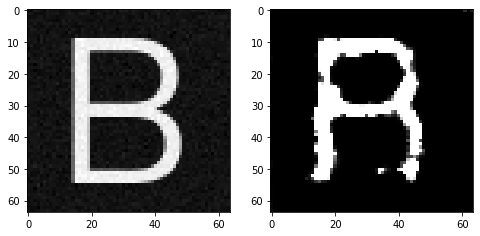

Epoch 15, Iteration 100, Loss D 1.1728916562860832, Loss Disc 434.749960899353, Loss Super 9.116784632205963


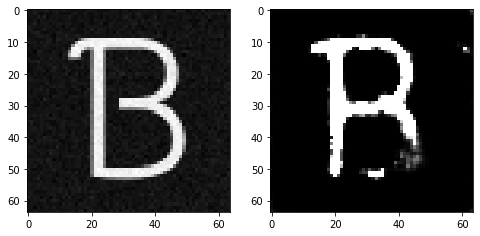

Epoch 16, Iteration 50, Loss D 1.9056744682602584, Loss Disc 448.2368679046631, Loss Super 8.973138004541397


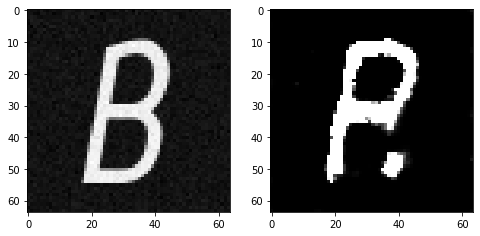

Epoch 16, Iteration 100, Loss D 7.841131433146074, Loss Disc 396.96726310253143, Loss Super 8.85130199790001


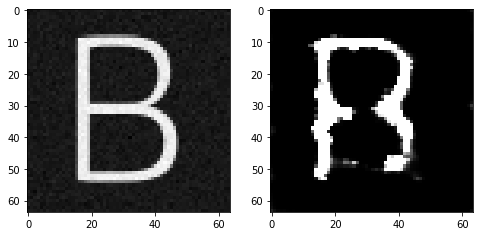

Epoch 17, Iteration 50, Loss D 2.8256399505771697, Loss Disc 375.00626611709595, Loss Super 8.656410127878189


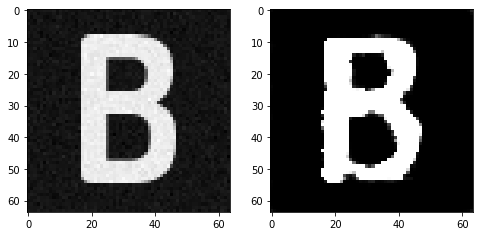

Epoch 17, Iteration 100, Loss D 0.8783821650067694, Loss Disc 393.5912718772888, Loss Super 8.846416413784027


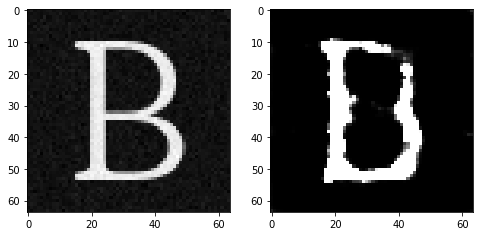

Epoch 18, Iteration 50, Loss D 1.6250109148095362, Loss Disc 404.45053911209106, Loss Super 8.699472829699516


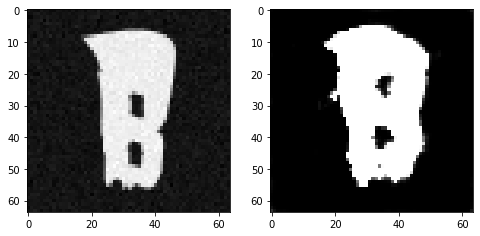

Epoch 18, Iteration 100, Loss D 0.4214718599978369, Loss Disc 402.9241142272949, Loss Super 8.513480350375175


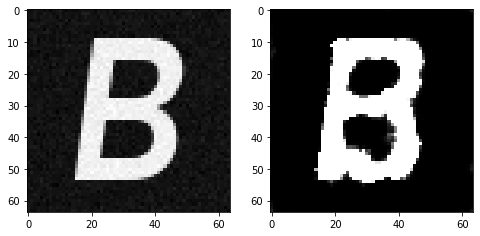

Epoch 19, Iteration 50, Loss D 0.33198977896245196, Loss Disc 425.17892360687256, Loss Super 8.50548304617405


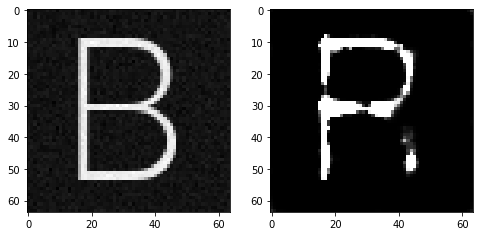

Epoch 19, Iteration 100, Loss D 0.3668007701198803, Loss Disc 440.00283193588257, Loss Super 8.539015367627144


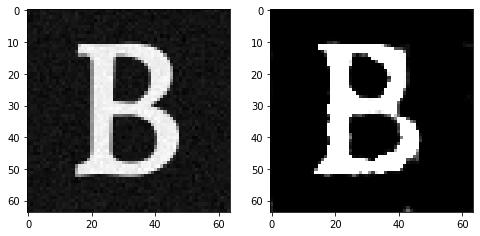

Epoch 20, Iteration 50, Loss D 0.5177386539144209, Loss Disc 455.70083475112915, Loss Super 8.423406898975372


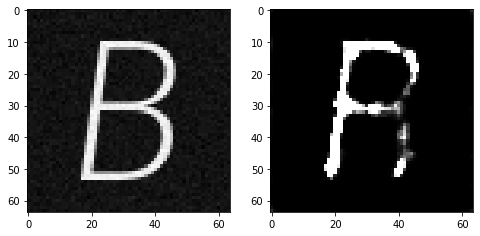

Epoch 20, Iteration 100, Loss D 0.2873498047265457, Loss Disc 458.56626081466675, Loss Super 8.559640869498253


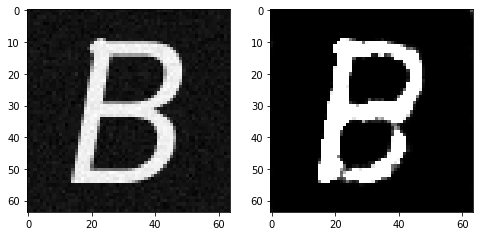

Epoch 21, Iteration 50, Loss D 3.9516614484164165, Loss Disc 448.11504435539246, Loss Super 8.572070226073265


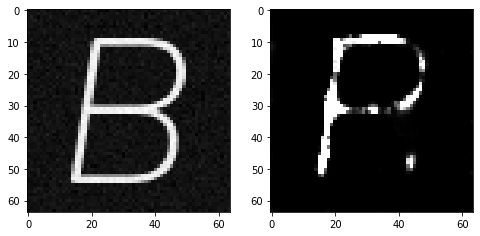

Epoch 21, Iteration 100, Loss D 10.244542620901484, Loss Disc 489.9071671962738, Loss Super 8.272579699754715


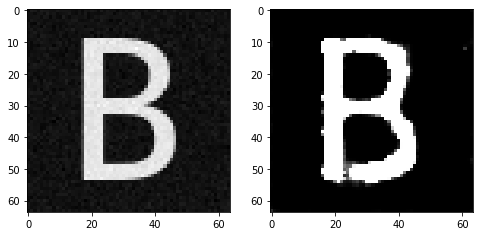

Epoch 22, Iteration 50, Loss D 0.6109955387655646, Loss Disc 476.8403334617615, Loss Super 8.273420721292496


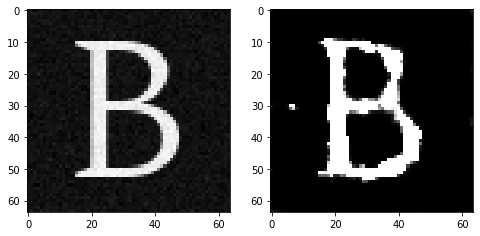

Epoch 22, Iteration 100, Loss D 0.4152849621459609, Loss Disc 497.03264713287354, Loss Super 8.423931166529655


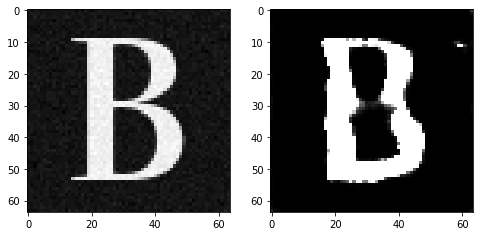

Epoch 23, Iteration 50, Loss D 0.3894441997690592, Loss Disc 452.0690231323242, Loss Super 8.32023899257183


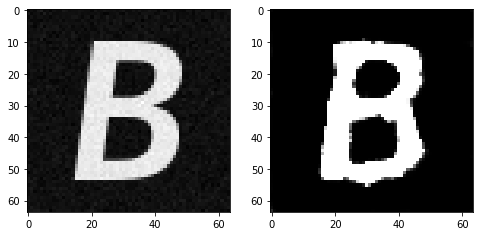

Epoch 23, Iteration 100, Loss D 0.41549751780257793, Loss Disc 454.59019327163696, Loss Super 8.353743359446526


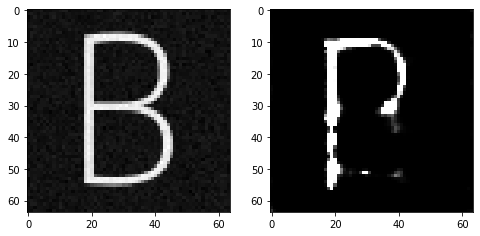

Epoch 24, Iteration 50, Loss D 0.3349031337129418, Loss Disc 478.38303232192993, Loss Super 8.180863738059998


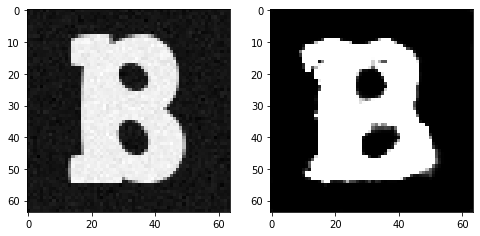

Epoch 24, Iteration 100, Loss D 0.37338541878852993, Loss Disc 449.12201595306396, Loss Super 8.469807744026184


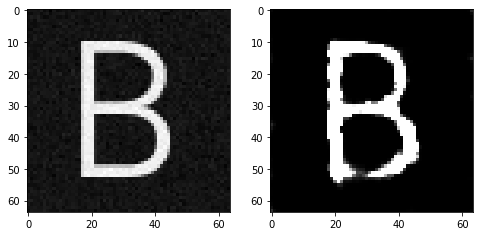

Epoch 25, Iteration 50, Loss D 0.6826033313991502, Loss Disc 495.7329487800598, Loss Super 8.23489062488079


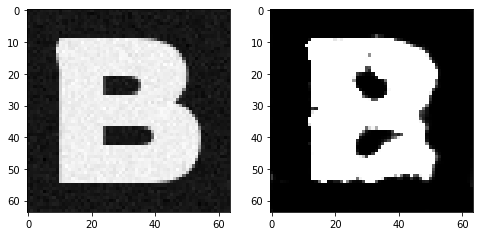

Epoch 25, Iteration 100, Loss D 0.2839353613599087, Loss Disc 508.72996520996094, Loss Super 8.286603689193726


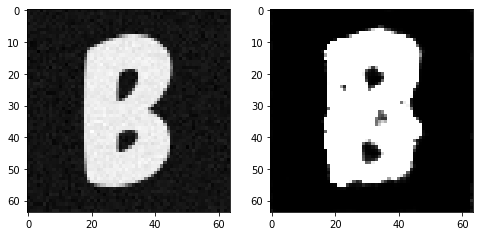

Epoch 26, Iteration 50, Loss D 0.32206919899908826, Loss Disc 494.8403491973877, Loss Super 8.289516434073448


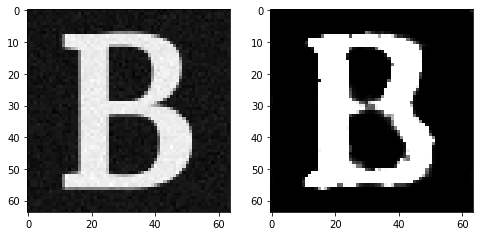

Epoch 26, Iteration 100, Loss D 0.40474540245486423, Loss Disc 471.9051113128662, Loss Super 8.081080213189125


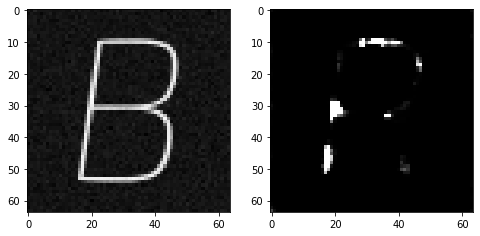

Epoch 27, Iteration 50, Loss D 0.32321274890273344, Loss Disc 496.04297971725464, Loss Super 8.104225978255272


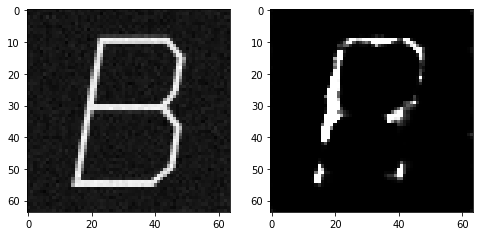

Epoch 27, Iteration 100, Loss D 0.19931360464397585, Loss Disc 521.1086354255676, Loss Super 8.239749282598495


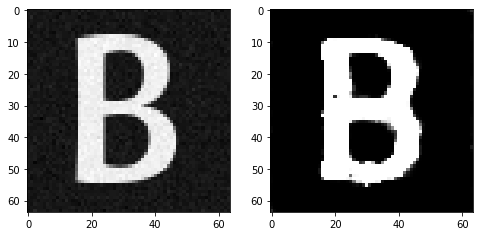

Epoch 28, Iteration 50, Loss D 0.27927037671906874, Loss Disc 515.6150498390198, Loss Super 8.255175426602364


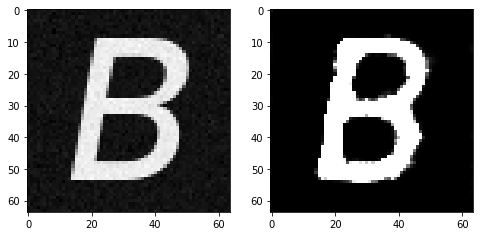

Epoch 28, Iteration 100, Loss D 0.6680332492833259, Loss Disc 512.3422045707703, Loss Super 8.114122062921524


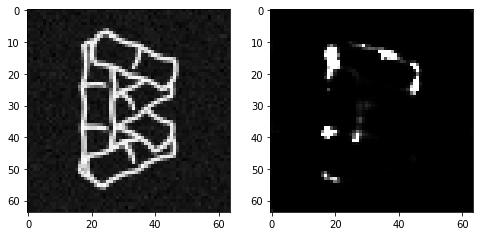

Epoch 29, Iteration 50, Loss D 1.8249373414582806, Loss Disc 523.1949939727783, Loss Super 8.035591334104538


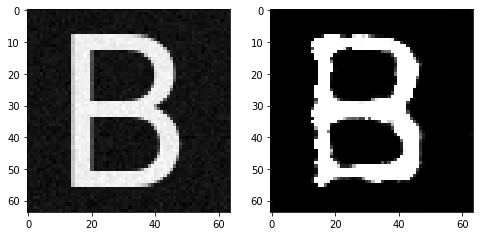

Epoch 29, Iteration 100, Loss D 6.9839694001711905, Loss Disc 419.29126167297363, Loss Super 8.18843425810337


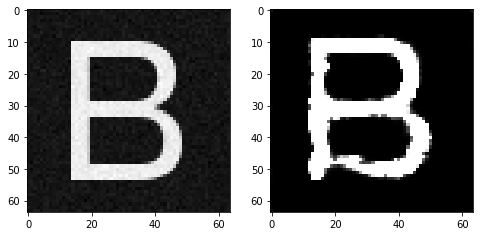

Epoch 30, Iteration 50, Loss D 0.8976597277214751, Loss Disc 453.8251643180847, Loss Super 8.09408538043499


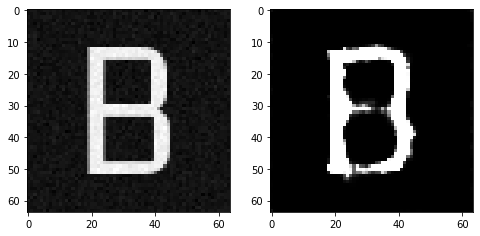

Epoch 30, Iteration 100, Loss D 0.42224505910417065, Loss Disc 482.7002444267273, Loss Super 8.098554119467735


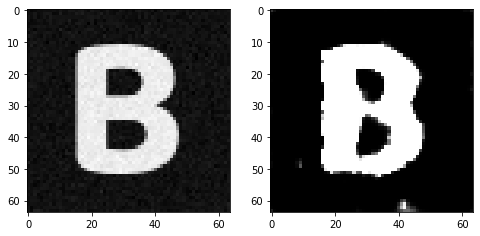

Epoch 31, Iteration 50, Loss D 0.4338255875845789, Loss Disc 469.0246925354004, Loss Super 8.051996648311615


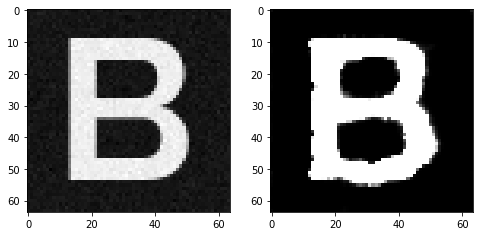

Epoch 31, Iteration 100, Loss D 0.38987504757824354, Loss Disc 468.9558997154236, Loss Super 8.036836221814156


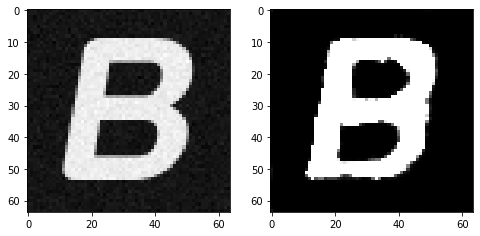

Epoch 32, Iteration 50, Loss D 0.22406197761301883, Loss Disc 515.1069641113281, Loss Super 8.119241163134575


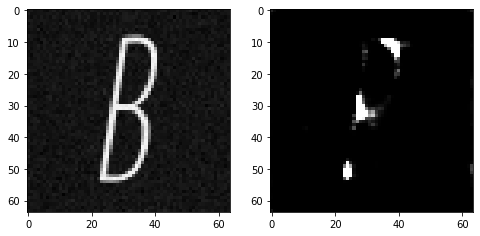

Epoch 32, Iteration 100, Loss D 0.8057215635344619, Loss Disc 494.39755606651306, Loss Super 7.978931427001953


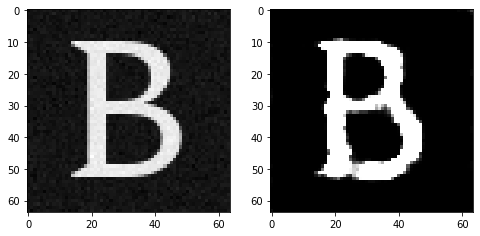

Epoch 33, Iteration 50, Loss D 1.3122852547239745, Loss Disc 510.8886580467224, Loss Super 8.07849070429802


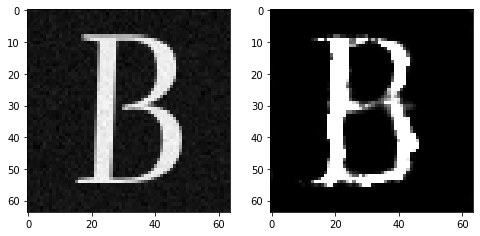

Epoch 33, Iteration 100, Loss D 0.2376036010500684, Loss Disc 531.6984791755676, Loss Super 7.990190848708153


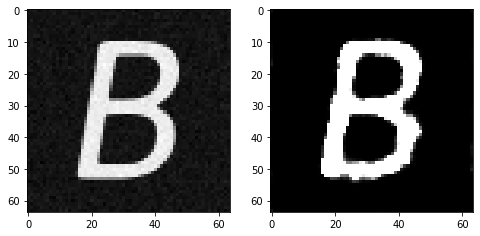

Epoch 34, Iteration 50, Loss D 0.5823563464873587, Loss Disc 528.8577275276184, Loss Super 7.972279071807861


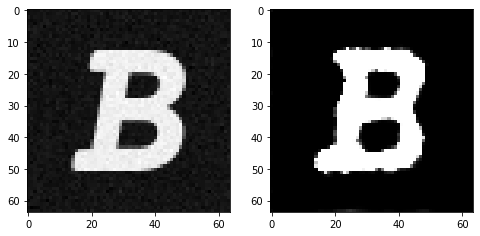

Epoch 34, Iteration 100, Loss D 0.4484642973402515, Loss Disc 517.6178288459778, Loss Super 8.052943840622902


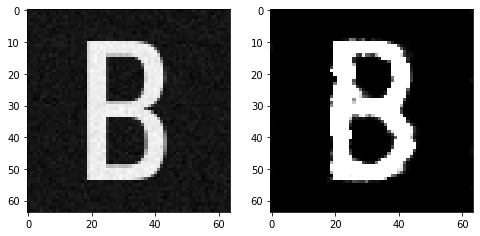

Epoch 35, Iteration 50, Loss D 4.531777165480889, Loss Disc 455.4699194431305, Loss Super 8.021021753549576


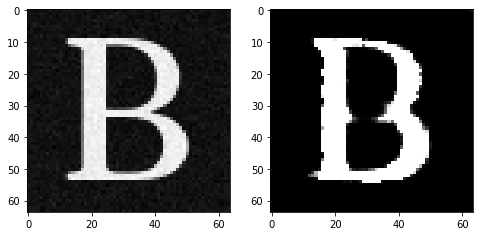

Epoch 35, Iteration 100, Loss D 1.687428316246951, Loss Disc 468.7105255126953, Loss Super 7.928534552454948


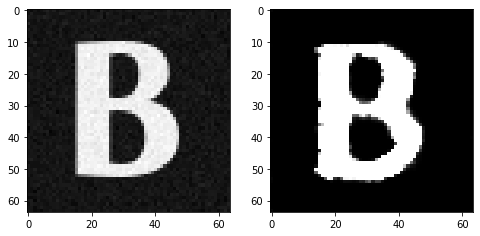

Epoch 36, Iteration 50, Loss D 0.6545019944969681, Loss Disc 475.3370170593262, Loss Super 8.048105895519257


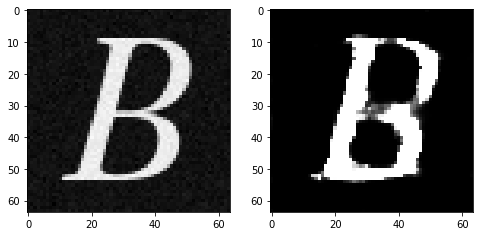

Epoch 36, Iteration 100, Loss D 0.7818330501759192, Loss Disc 512.5175242424011, Loss Super 7.863333284854889


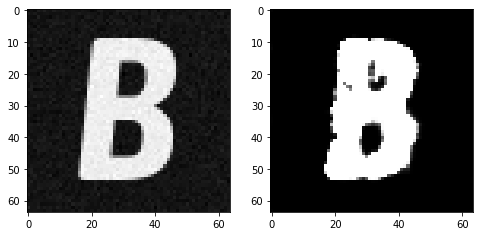

Epoch 37, Iteration 50, Loss D 0.729264951107325, Loss Disc 514.8344550132751, Loss Super 8.034155622124672


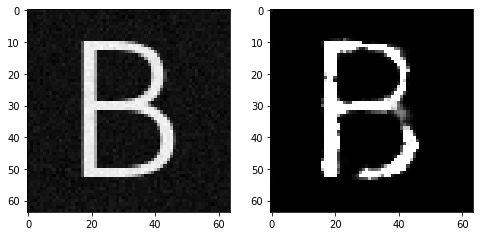

Epoch 37, Iteration 100, Loss D 0.6278202869216329, Loss Disc 511.40960121154785, Loss Super 7.926222011446953


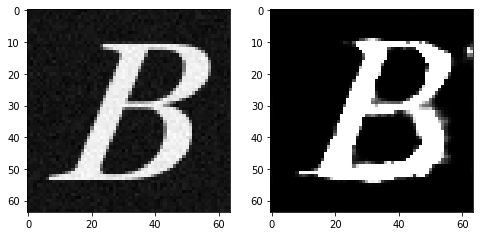

Epoch 38, Iteration 50, Loss D 0.09317472275870387, Loss Disc 534.6827945709229, Loss Super 7.752315536141396


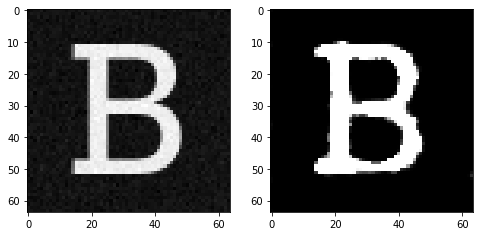

Epoch 38, Iteration 100, Loss D 0.14718834913583123, Loss Disc 545.6129469871521, Loss Super 8.02386038005352


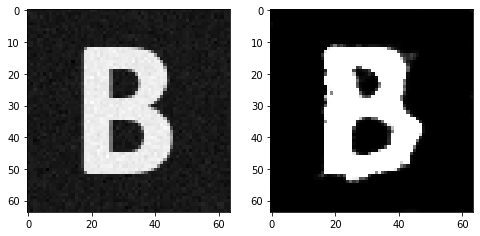

Epoch 39, Iteration 50, Loss D 0.301405400638032, Loss Disc 553.3855323791504, Loss Super 7.899602249264717


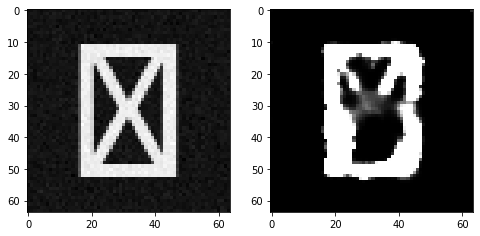

Epoch 39, Iteration 100, Loss D 0.10112845587718766, Loss Disc 538.8628091812134, Loss Super 7.927335515618324


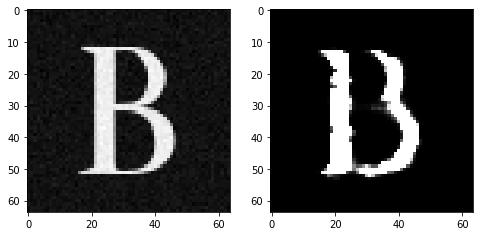

Epoch 40, Iteration 50, Loss D 0.11655860397877404, Loss Disc 571.763099193573, Loss Super 7.913389623165131


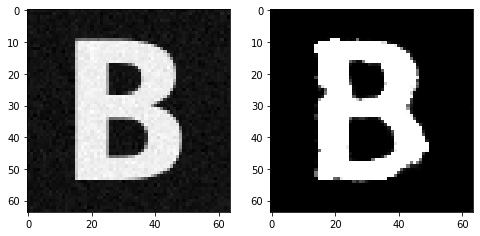

Epoch 40, Iteration 100, Loss D 0.201142002690176, Loss Disc 525.062539100647, Loss Super 7.947302877902985


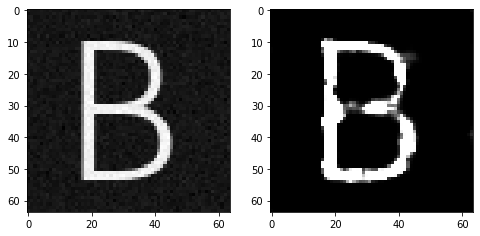

Epoch 41, Iteration 50, Loss D 0.23990155589672213, Loss Disc 555.2598338127136, Loss Super 7.9150560349226


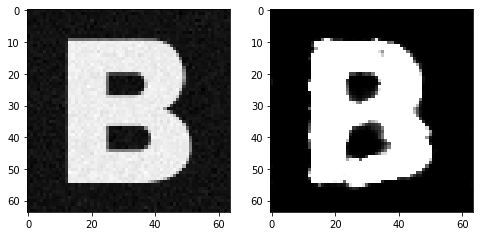

Epoch 41, Iteration 100, Loss D 0.21187093505068333, Loss Disc 558.9876194000244, Loss Super 7.8263710886240005


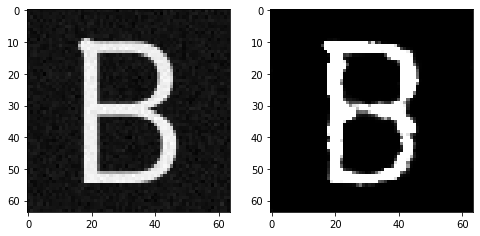

Epoch 42, Iteration 50, Loss D 0.3855567642967799, Loss Disc 548.4160408973694, Loss Super 7.819506034255028


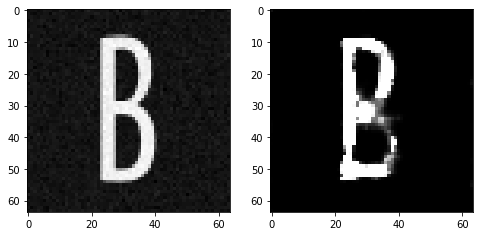

Epoch 42, Iteration 100, Loss D 1.7181947666831547, Loss Disc 518.649115562439, Loss Super 7.990135908126831


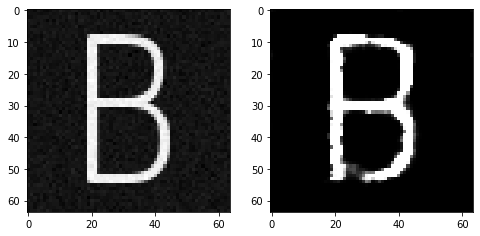

Epoch 43, Iteration 50, Loss D 0.2193415887231822, Loss Disc 532.1250591278076, Loss Super 7.894708812236786


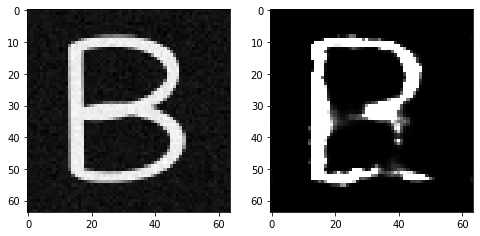

Epoch 43, Iteration 100, Loss D 0.20326813044084702, Loss Disc 557.8301944732666, Loss Super 7.8012300580739975


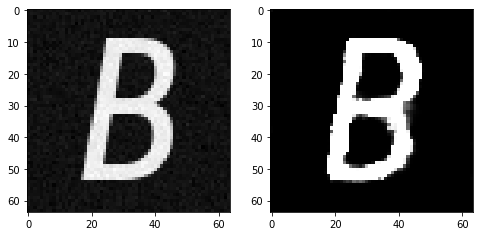

Epoch 44, Iteration 50, Loss D 0.09458293858915567, Loss Disc 530.8652443885803, Loss Super 7.7387649565935135


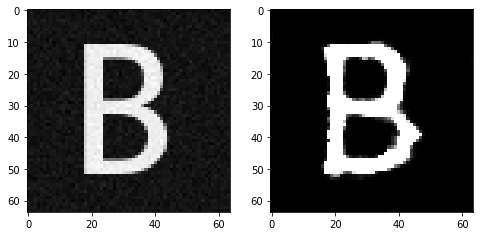

Epoch 44, Iteration 100, Loss D 0.169542329153046, Loss Disc 576.1107935905457, Loss Super 7.818214952945709


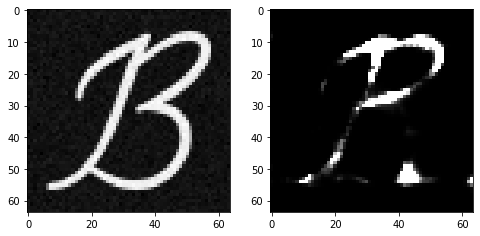

Epoch 45, Iteration 50, Loss D 0.09415994399023475, Loss Disc 574.2586812973022, Loss Super 8.003155156970024


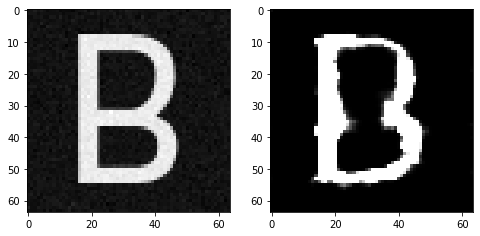

Epoch 45, Iteration 100, Loss D 0.08817594850552268, Loss Disc 592.0062108039856, Loss Super 7.738045945763588


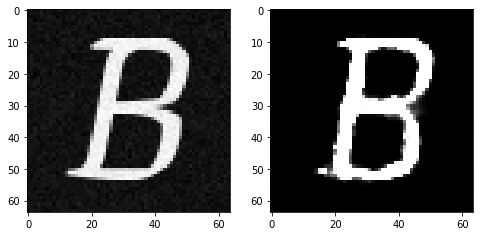

Epoch 46, Iteration 50, Loss D 0.04399832576018525, Loss Disc 563.1611576080322, Loss Super 7.645699977874756


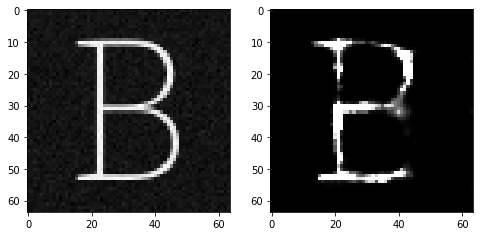

Epoch 46, Iteration 100, Loss D 0.06129636024070351, Loss Disc 557.6186532974243, Loss Super 7.895859315991402


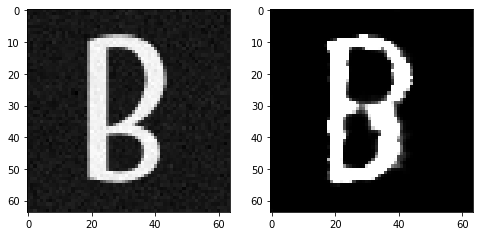

Epoch 47, Iteration 50, Loss D 0.08684206521684246, Loss Disc 563.8843488693237, Loss Super 7.820357337594032


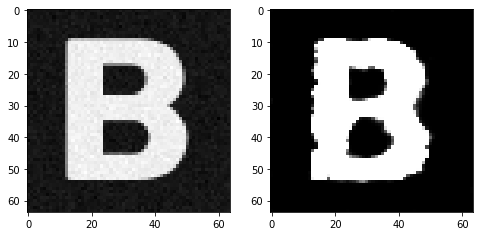

Epoch 47, Iteration 100, Loss D 0.0838553789708385, Loss Disc 602.5204672813416, Loss Super 7.707576647400856


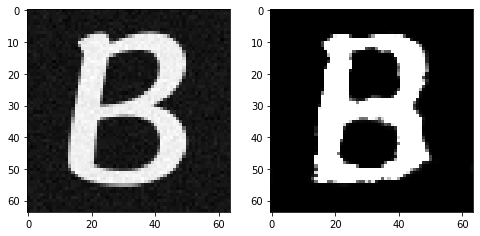

Epoch 48, Iteration 50, Loss D 0.06092154567340913, Loss Disc 570.3503942489624, Loss Super 7.858127772808075


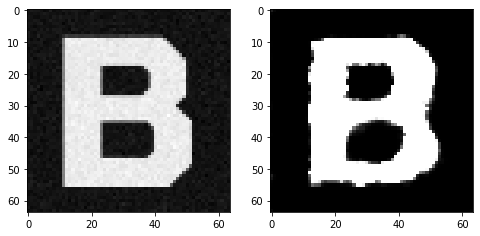

Epoch 48, Iteration 100, Loss D 0.3905992911240901, Loss Disc 550.4182758331299, Loss Super 7.708878502249718


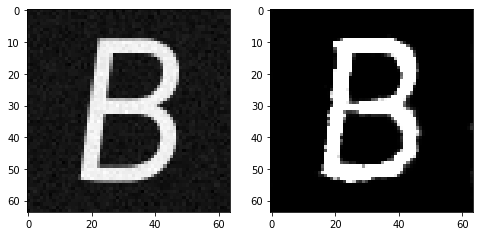

Epoch 49, Iteration 50, Loss D 0.07181499471153074, Loss Disc 604.5066437721252, Loss Super 7.691863536834717


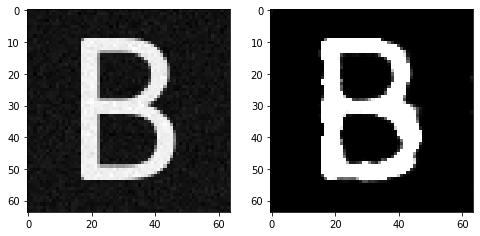

Epoch 49, Iteration 100, Loss D 0.9147874437821883, Loss Disc 555.5025644302368, Loss Super 7.8333002626895905


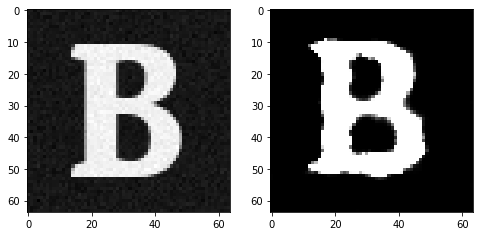

Epoch 50, Iteration 50, Loss D 10.08915081282612, Loss Disc 447.54366290569305, Loss Super 7.671596139669418


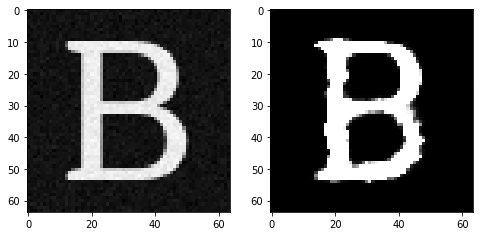

Epoch 50, Iteration 100, Loss D 0.3648987017804757, Loss Disc 505.52184200286865, Loss Super 7.918498307466507


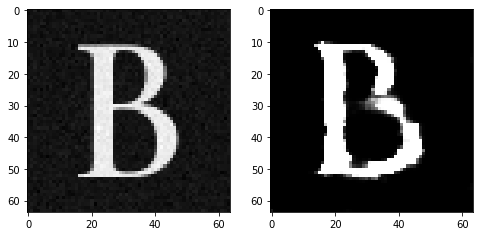

Done


In [43]:
main()

In [44]:
# path to font list
fonts_csv = "fonts.csv"
# root directory for dataset
dataroot = "images"
# number of workers for dataloader
workers = 0

dataset = FontDataset(csv_file=fonts_csv, 
                      root_dir=dataroot, 
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize(0.5, 0.5),
                      ]))

In [45]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=workers)

encdec = EncoderDecoder()
encdec.load_state_dict(torch.load('encdec.pt'))
encdec.eval()

EncoderDecoder(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2back): Conv2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1back): Conv2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1strided): Conv2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2strided): Conv2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(4, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (deconv1strided): ConvTranspose2d(4, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (deconv2strided): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (batchnorm0): BatchNorm2d(1, ep

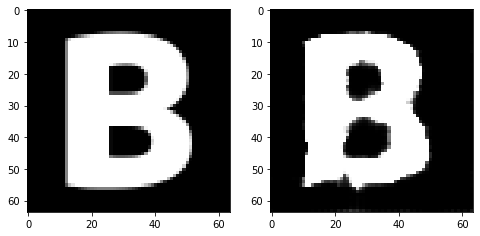

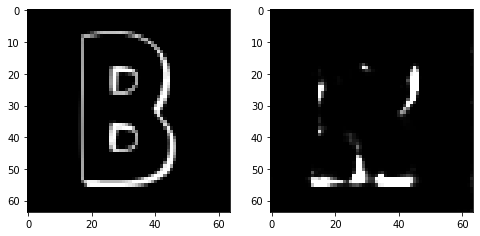

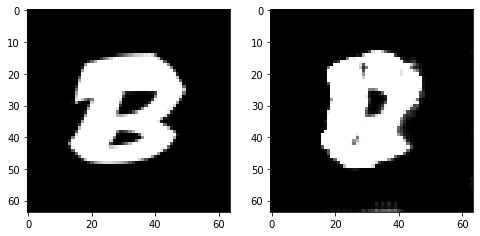

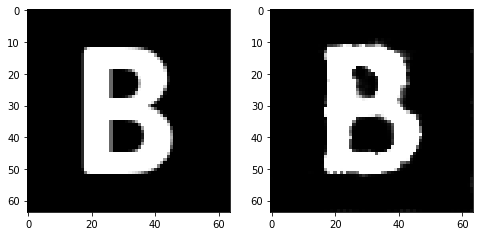

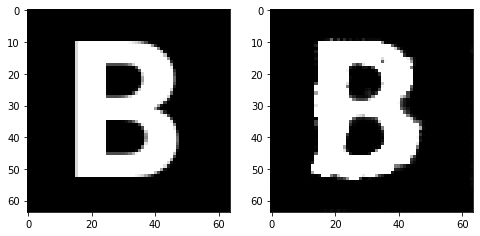

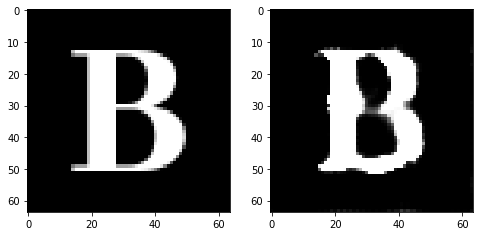

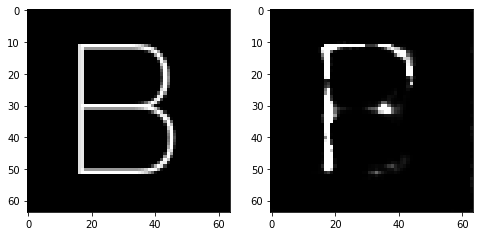

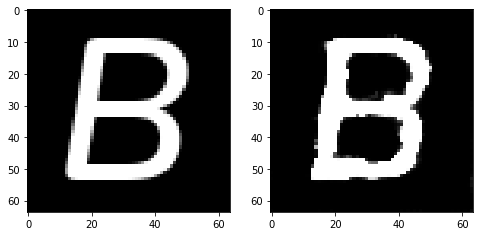

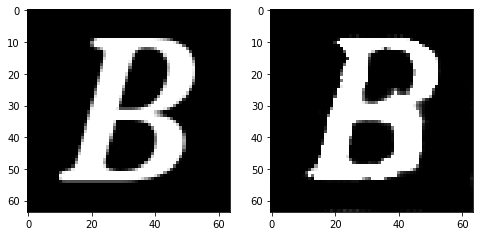

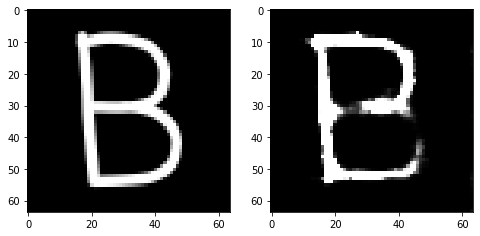

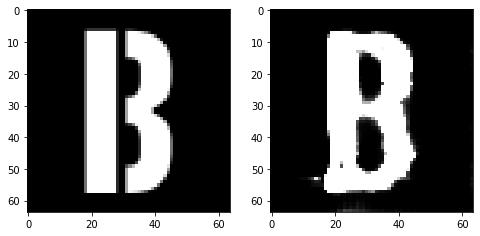

In [46]:
for i, data in enumerate(dataloader):
    if i > 10:
        break
    fig = plt.figure(figsize=(8, 8))
    output = encdec(data['c1'])
    fig.add_subplot(1, 2, 1)
    plt.imshow(data['c2'][0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    fig.add_subplot(1, 2, 2)
    plt.imshow(output[0].permute(1, 2, 0).detach().numpy(), cmap='gray')
    plt.show()

3240.npy
./fonts/SometypeMono-Regular.ttf


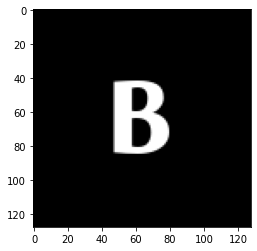

1952.npy
./fonts/AlegreyaSC-Italic.ttf


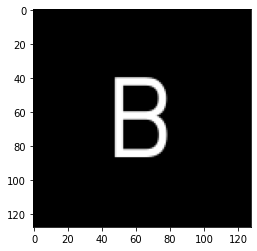

616.npy
./fonts/Heebo-Medium.ttf


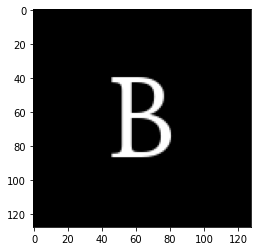

1418.npy
./fonts/RedHatDisplay-Black.ttf


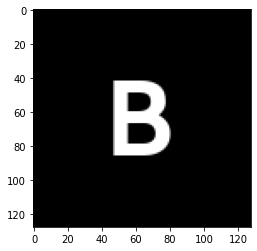

3171.npy
./fonts/BarlowCondensed-LightItalic.ttf


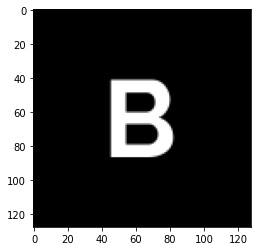

1139.npy
./fonts/CabinSketch-Bold.ttf


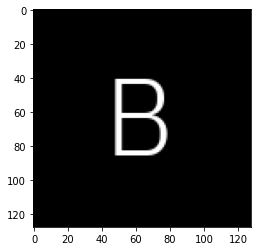

1918.npy
./fonts/Mina-Regular.ttf


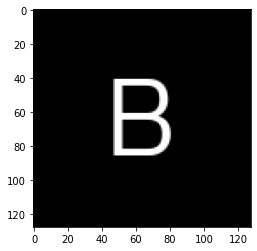

3199.npy
./fonts/Sunflower-Medium.ttf


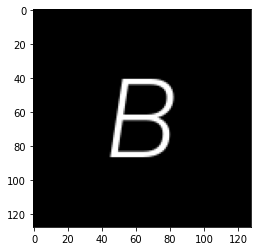

80.npy
./fonts/LibreFranklin-Italic[wght].ttf


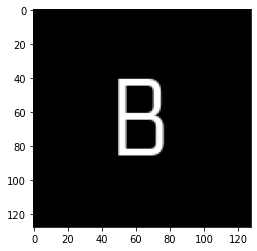

3749.npy
./fonts/ZillaSlab-Regular.ttf


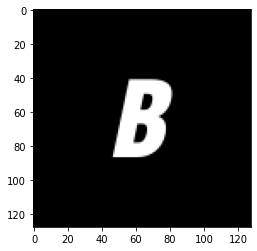

1428.npy
./fonts/CrimsonText-Regular.ttf


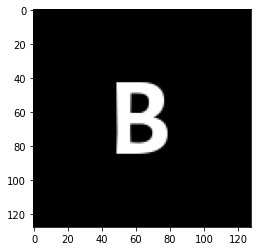

1366.npy
./fonts/CabinSketch-Regular.ttf


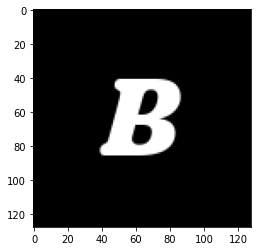

1280.npy
./fonts/Stylish-Regular.ttf


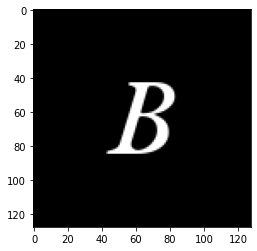

745.npy
./fonts/Radley-Italic.ttf


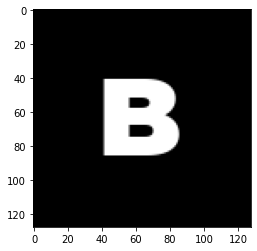

2368.npy
./fonts/Trispace-ExtraLight.ttf


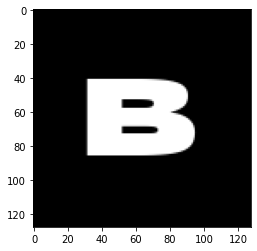

2289.npy
./fonts/Inconsolata-ExtraLight.ttf


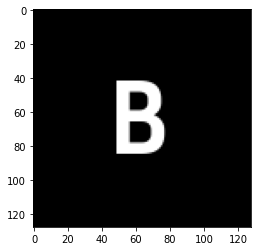

451.npy
./fonts/GothicA1-Black.ttf


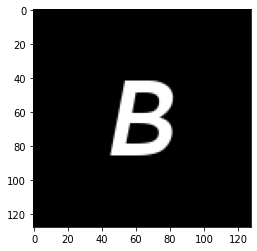

620.npy
./fonts/Rokkitt-Regular.ttf


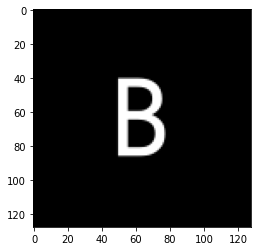

3626.npy
./fonts/SeoulHangangCondensed-ExtraBold.ttf


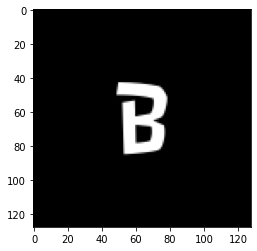

230.npy
./fonts/Rubik[wght].ttf


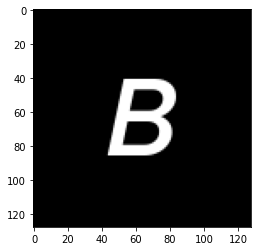

3398.npy
./fonts/Thasadith-BoldItalic.ttf


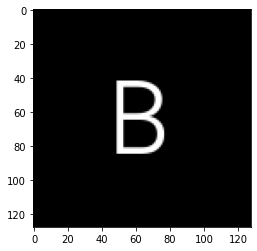

513.npy
./fonts/GeoramaExtraExpanded-SemiBold.ttf


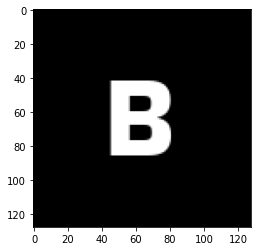

3053.npy
./fonts/LilyScriptOne-Regular.ttf


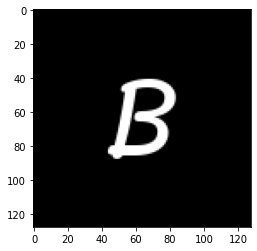

1879.npy
./fonts/BioRhyme-ExtraBold.ttf


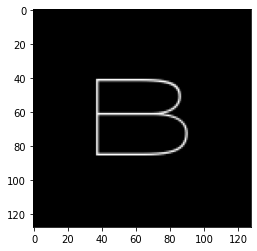

778.npy
./fonts/Lato-LightItalic.ttf


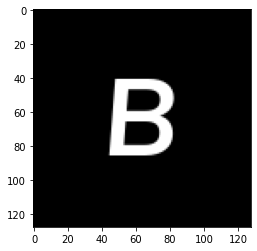

3588.npy
./fonts/Livvic-Medium.ttf


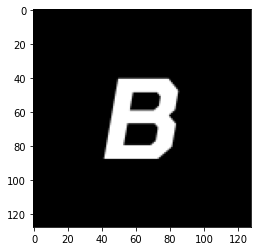

2327.npy
./fonts/GeoramaExtraExpanded-Black.ttf


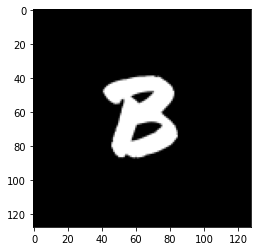

1529.npy
./fonts/Barlow-Bold.ttf


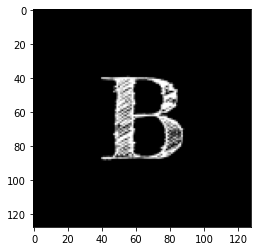

3338.npy
./fonts/Amaranth-Italic.ttf


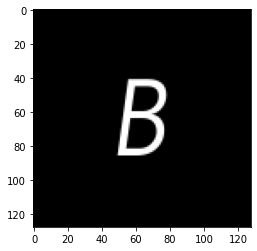

557.npy
./fonts/ExpletusSans-SemiBold.ttf


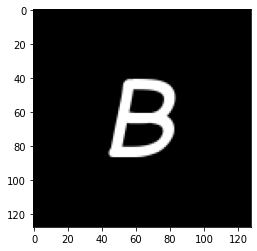

69.npy
./fonts/Petrona-LightItalic.ttf


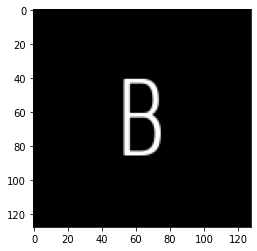

991.npy
./fonts/Sarabun-ExtraBoldItalic.ttf


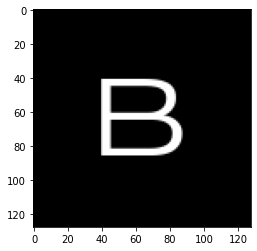

2768.npy
./fonts/Ubuntu-Bold.ttf


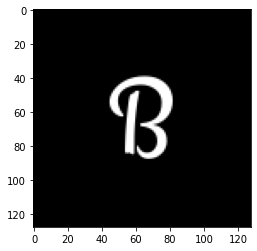

2789.npy
./fonts/HindMadurai-Bold.ttf


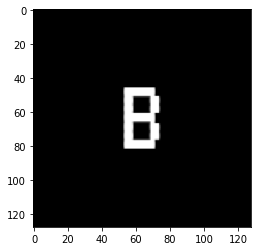

3331.npy
./fonts/AsapCondensed-Regular.ttf


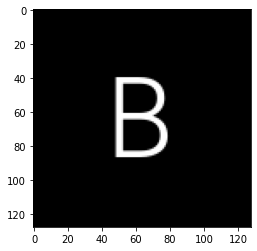

1885.npy
./fonts/Arvo-Regular.ttf


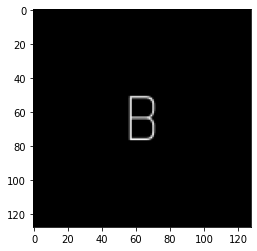

1654.npy
./fonts/RobotoMono-Italic.ttf


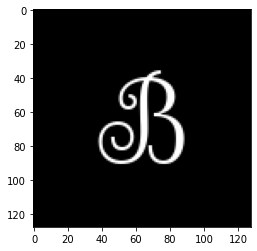

3783.npy
./fonts/GeoramaExtraExpanded-Italic.ttf


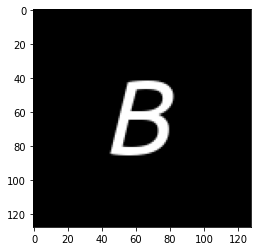

634.npy
./fonts/NanumMyeongjo-ExtraBold.ttf


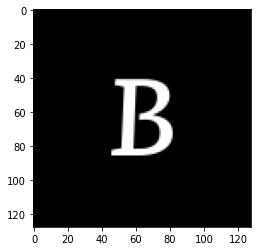

3003.npy
./fonts/GeoramaCondensed-SemiBold.ttf


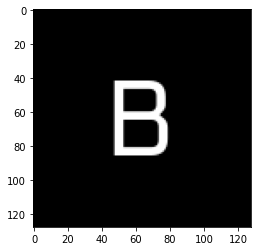

1506.npy
./fonts/Enriqueta-Bold.ttf


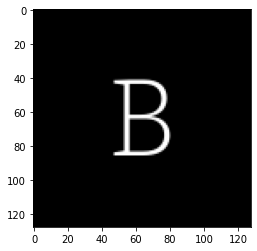

3009.npy
./fonts/AlegreyaSC-Regular.ttf


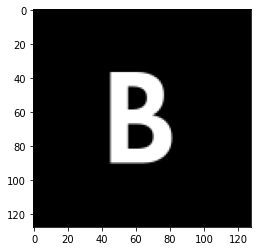

275.npy
./fonts/Radley-Regular.ttf


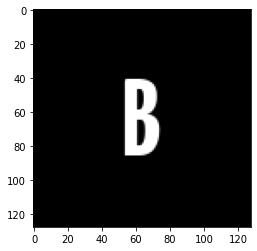

2049.npy
./fonts/IBMPlexMono-Light.ttf


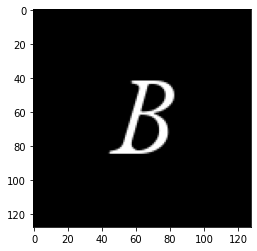

1522.npy
./fonts/IBMPlexSansCondensed-Italic.ttf


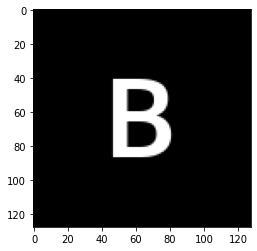

402.npy
./fonts/Kodchasan-ExtraLight.ttf


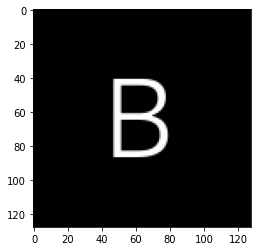

1802.npy
./fonts/TurretRoad-ExtraBold.ttf


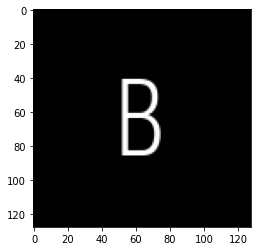

2265.npy
./fonts/ZCOOLQingKeHuangYou-Regular.ttf


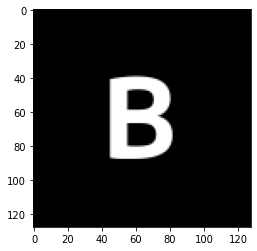

3932.npy


KeyError: 3932

In [57]:
font_set = pd.read_csv('fonts.csv', sep=' ', header=None)

letter_dir = './images/B'
for file in os.listdir(letter_dir):
    print(file)
    img = np.load(os.path.join(letter_dir, file))
    
    num = int(file.split('.')[0])
    font_name = font_set[1][num]
    print(font_name)
    
    plt.imshow(img, cmap='gray')
    plt.show()